# Creating custom datablocks for 3D images and fastai

In [ ]:
# hide
import sys
sys.path.append("..")
from nbdev.showdoc import *

In [ ]:
# export
# default_exp data

import SimpleITK as sitk
import re
import pathlib
import torchvision

from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [ ]:
# export
from faimed3d.basics import *
from faimed3d.augment import *


## Get data paths and labels

Data is divided into a train, valid and test dataset of different patients, which either have prostate cancer or are healthy. 
Each patient has three MRI sequences: T2, T1map and ADC. These sequences differ in number of slices and resolution. 

At first the paths to the data are specified: 

In [ ]:
sample_data = pd.read_csv('../../dl-prostate-mapping/data/prostata-train.csv', sep = ',')
sample_data = sample_data[['t2_dcm_path', "t2_mask_base", 'is_valid']]

In [ ]:
# export
class ScaleDicom(DisplayedTransform):
    "Transforms a TensorDicom3D volume to float and normalizes the data"
    def __init__(self, div=None, scale=True, normalize='mean'): store_attr()
    def encodes(self, x:(TensorDicom3D, TensorMask3D)):
        if isinstance(x, TensorMask3D): return x
        if self.normalize == 'mean': x=x.normalize('mean')
        if self.normalize == 'median': x=x.normalize('median')
        if self.normalize == 'max': x=x.normalize('max')
        if self.scale: x=x.hist_scaled()
        if self.div is not None: x=x/self.div
        return x.float()

In [ ]:
# export
def ImageBlock3D(cls=TensorDicom3D, div=None,scale=True, normalize='mean'):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=[ScaleDicom(div=div,scale=scale,normalize=normalize)])

def MaskBlock3D(cls=TensorMask3D):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=[ScaleDicom])

## Dataloaders for image classification problems

In [ ]:
mris = DataBlock(
    blocks = (ImageBlock3D(cls=TensorDicom3D), 
              ImageBlock3D(cls=TensorMask3D)),
    get_x = lambda x: x[0],
    get_y = lambda x: x[1], 
    item_tfms = ResizeCrop3D(crop_by = (0., 0.1, 0.1), resize_to = (20, 150, 150), perc_crop = True),
    batch_tfms = [
        *aug_transforms_3d(), 
        RandomCrop3D(((3, 2), (25,25), (25,25)), (0, 25, 25)), 
        PseudoColor],
    splitter = RandomSplitter())

In [ ]:
dls = mris.dataloaders(sample_data, 
                       batch_size = 8, 
                       num_workers = 0
                      )
dls.valid.bs = 8 # defaults to 64 and will cause Cuda out of Memory errors

In [ ]:
# export
def show_batch_3d(dls, max_n=9, with_mask=False, alpha_mask=0.3, figsize = (15, 15), **kwargs):
    "Workarround, until implemented into dls as dls.show_batch_3d()"
    xb, yb = dls.one_batch()
    xb.show(figsize=figsize, **kwargs)
    if with_mask: yb.show(add_to_existing = True, alpha = alpha_mask, cmap = 'jet', figsize=figsize, **kwargs)    

../faimed3d/basics.py:61: UserWarning: Object is not a rank 3 tensor but a rank 4 tensor. Assuming the 1st dimension is a (fake) color channel it will be removed
  warn(w)


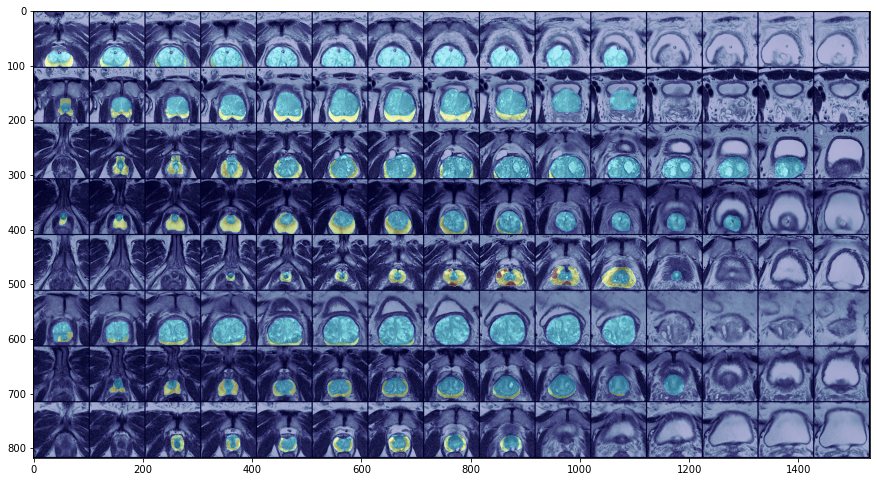

In [ ]:
show_batch_3d(dls, axis = 0, nrow = 15, with_mask=True)

In [ ]:
dls.after_item

In [ ]:
dls.after_batch

When displaying the masks it may occure, that Nifti images are rotated and do not fit the original DICOM. Most likely it is due to different frames of reference. 
in Simple-ITK it is LPS, while NIfTI and FSL use RAS, so those matrices are the same after accounting for frame of reference (taken and adapted from https://discourse.itk.org/t/nifti-orientation-issues/431).
So, luckly the malrotations are systematic and can be scripted.

```python
    def convert(fn):

        if 'Gesund' in fn: return # healthy patients were already flipped once
        im = sitk.ReadImage(fn)
        arr = sitk.GetArrayFromImage(im)
        arr = np.rot90(arr, 0)
        arr = np.flip(arr, 1)
        im2 = sitk.GetImageFromArray(arr)

        for k in im.GetMetaDataKeys(): # Copy meta data from original image before overwriting it. 
            im2.SetMetaData(k, im.GetMetaData(k))

        sitk.WriteImage(im2, fn)
        return im2
    
    
    for s in segmentation_train: 
    convert(str(s))
````

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 01_basics.ipynb.
Converted 02_transforms.ipynb.
Converted 03_datablock.ipynb.
Converted 04_datasets.ipynb.
Converted 05a_models.modules.ipynb.
Converted 05b_models.alexnet.ipynb.
Converted 05b_models.deeplabv3.ipynb.
Converted 05b_models.densenet.ipynb.
Converted 05b_models.resnet.ipynb.
Converted 05c_models.DynamicUnet.ipynb.
Converted 05c_models.siamese.ipynb.
Converted 05c_models.unet.ipynb.
Converted 05d_models.losses.ipynb.
Converted 06_callback.ipynb.
Converted 99_tools.ipynb.
Converted index.ipynb.
